## Example of likelihood maximization with iMinuit

This notebook contains the basic syntax required to run iMinuit on eBOSS P1D data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
import time
# our own modules
from lace.emulator import gp_emulator
from lace.emulator import nn_emulator
from cup1d.data import data_Chabanier2019
from cup1d.data import data_Karacayli2022
from cup1d.likelihood import lya_theory
from cup1d.likelihood import likelihood
from cup1d.likelihood import iminuit_minimizer

### Set up data (eBOSS P1D measurement from Chabanier et al. 2019)

In [2]:
zmin=2.7
zmax=3.3
plot_every_iz=1

In [3]:
data=data_Chabanier2019.P1D_Chabanier2019(zmin=zmin,zmax=zmax)

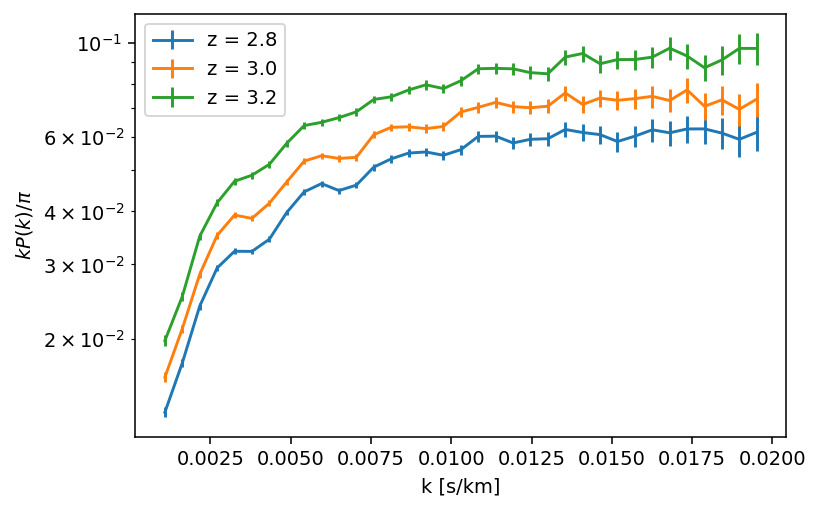

In [4]:
data.plot_p1d()

### Set up high-res extra data (eBOSS P1D measurement from Karacayli et al. 2022)

Nz = 15 , Nk = 21


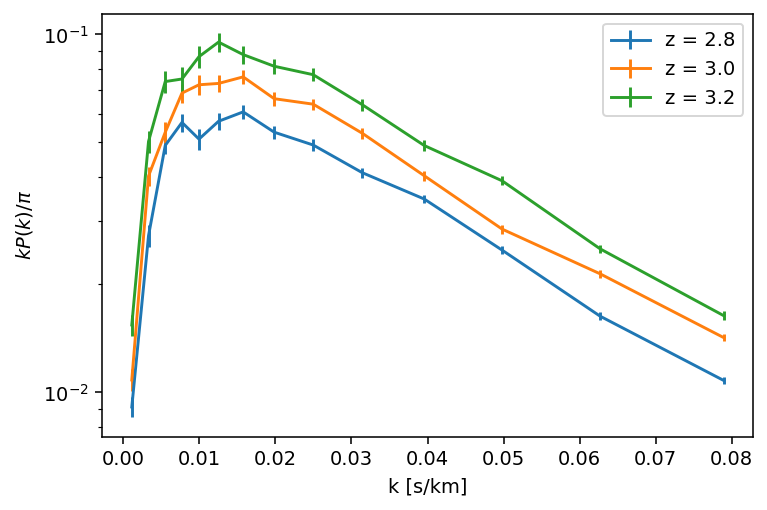

In [5]:
add_hires=True
if add_hires:
    extra_data=data_Karacayli2022.P1D_Karacayli2022(zmin=zmin,zmax=zmax)
    extra_data.plot_p1d()
    emu_kmax_Mpc=8
    emu_ndeg=7
else:
    extra_data=None
    emu_kmax_Mpc=4
    emu_ndeg=5

### Setup an emulator (Nyx, LaCE-GP or LaCE-NN)

In [6]:
emulator_label="LaCE-GP"
if emulator_label=="LaCE-GP":
#    emulator=gp_emulator.GPEmulator(training_set="Cabayol23", kmax_Mpc=emu_kmax_Mpc, ndeg=emu_ndeg)
    emulator=gp_emulator.GPEmulator(training_set="Pedersen21", kmax_Mpc=emu_kmax_Mpc, ndeg=emu_ndeg)
elif emulator_label=="LaCE-NN":
    assert not add_hires,"NN emulator not trained beyond k=4 1/Mpc"
    emulator=nn_emulator.NNEmulator(training_set="Cabayol23", emulator_label="Cabayol23")
elif args.emulator_label=="Nyx":
    assert not add_hires,"Nyx emulator not trained beyond k=4 1/Mpc"
    emulator=nn_emulator.NNEmulator(training_set="Nyx23", emulator_label="Cabayol23_Nyx")
else:
    raise ValueError("wrong emulator_label",emulator_label)

Selected training set from Pedersen21
Selected custom emulator


 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 330 points
GPs optimised in 1.84 seconds


### Setup a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and emulator objects to the likelihood.

In [7]:
free_cosmo=False
if free_cosmo:
    # stick to primordial power-law parameters here
    free_param_names=["As","ns"]
else:
    free_param_names=[]
# specify the number of free parameters per IGM function (default=2)
n_igm=1
for i in range(n_igm):
    for par in ["tau","sigT_kms","gamma","kF"]:
        free_param_names.append('ln_{}_{}'.format(par,i))
# add metal line contaminations
free_param_names.append('ln_SiIII_0')

In [8]:
theory=lya_theory.Theory(zs=data.z,emulator=emulator,free_param_names=free_param_names)

metal tag ln_SiIII


In [9]:
theory.metal_models[0].get_dv_kms()

2260.6866995155115

In [10]:
# option to include/remove a Gaussian prior (in unit cube)
prior_Gauss_rms=None
# option to include/ignore emulator covariance (it might bias the results)
emu_cov_factor=0
like=likelihood.Likelihood(data=data,
                            theory=theory,
                            free_param_names=free_param_names,
                            prior_Gauss_rms=prior_Gauss_rms,
                            emu_cov_factor=emu_cov_factor,
                            extra_p1d_data=extra_data)

will not store truth, working with real data
will not store truth, working with real data


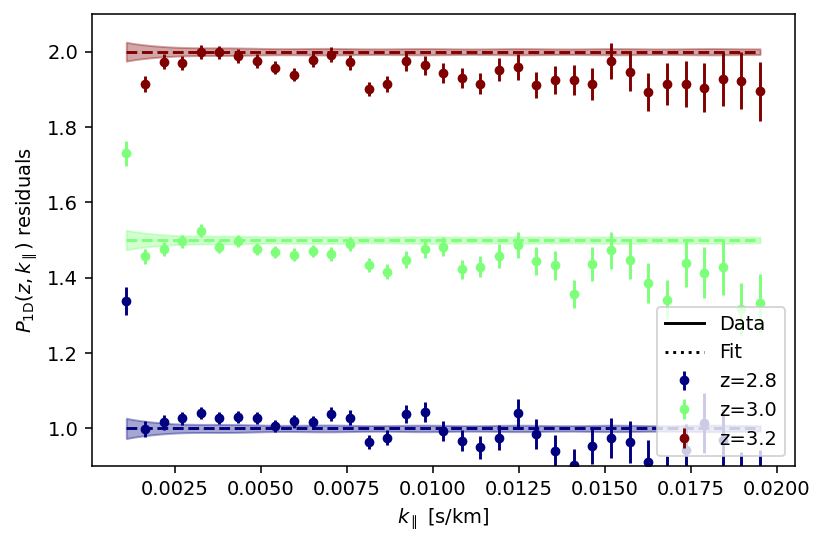

In [11]:
like.plot_p1d(residuals=True,plot_every_iz=plot_every_iz)

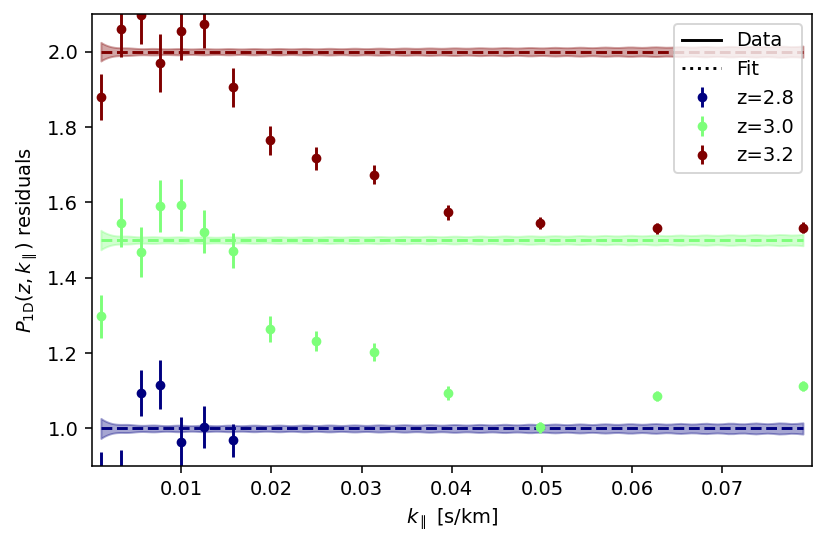

In [12]:
if extra_data:
    like.extra_p1d_like.plot_p1d(residuals=True,plot_every_iz=plot_every_iz)

# Try iminuit minimizer

In [13]:
test_values=len(free_param_names)*[0.5]
ini_chi2=like.get_chi2(values=test_values)
print('chi2 =',ini_chi2)

chi2 = 566.416502461367


In [14]:
minimizer = iminuit_minimizer.IminuitMinimizer(like)

In [15]:
minimizer.minimize(compute_hesse=True)

In [16]:
best_fit_values=np.array(minimizer.minimizer.values)
print('best fit values',best_fit_values)
best_chi2=like.get_chi2(values=best_fit_values)
print('chi2 improved from {} to {}'.format(ini_chi2,best_chi2))

best fit values [0.16702862 0.7735955  0.84524022 0.42880684 0.73273776]
chi2 improved from 566.416502461367 to 283.2437896008526


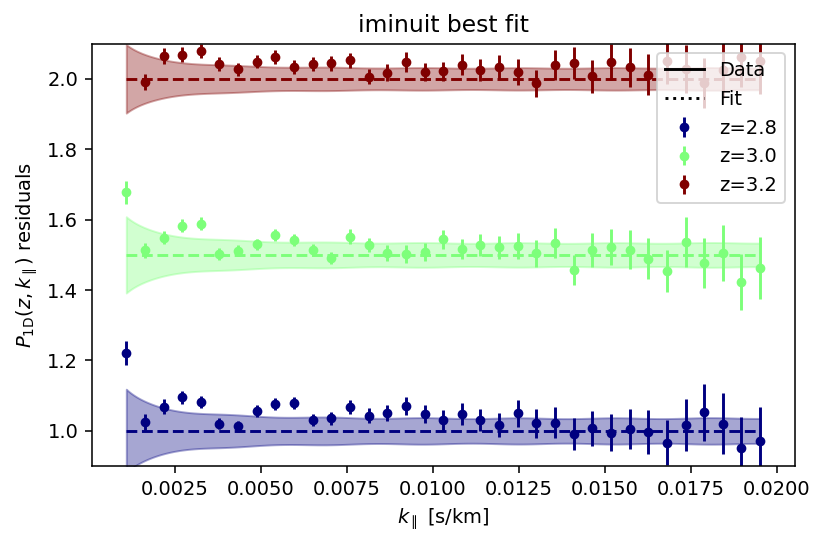

In [17]:
minimizer.plot_best_fit(plot_every_iz=plot_every_iz,residuals=True)

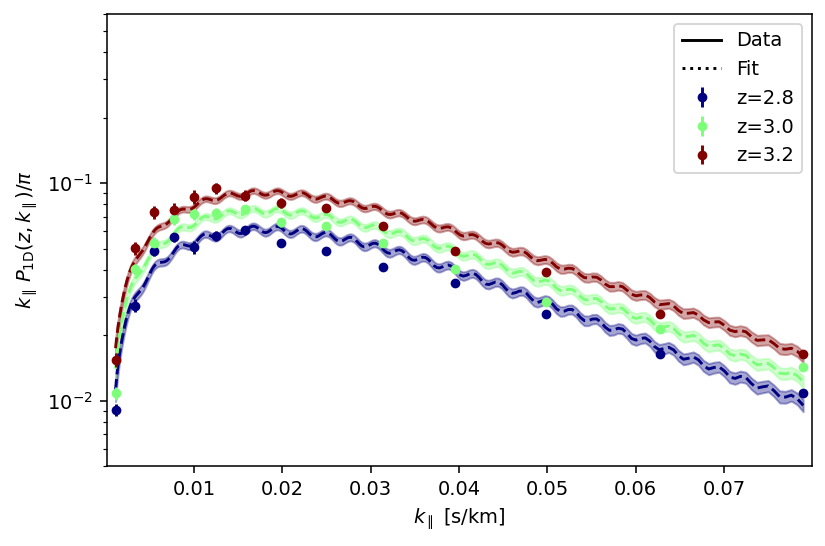

In [18]:
if extra_data:
    like.extra_p1d_like.plot_p1d(values=best_fit_values,residuals=False,plot_every_iz=plot_every_iz)

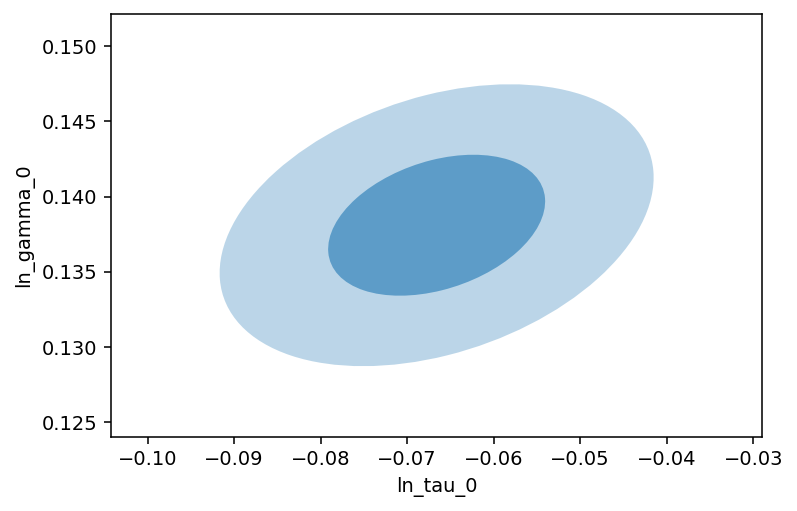

In [19]:
minimizer.plot_ellipses('ln_tau_0','ln_gamma_0')

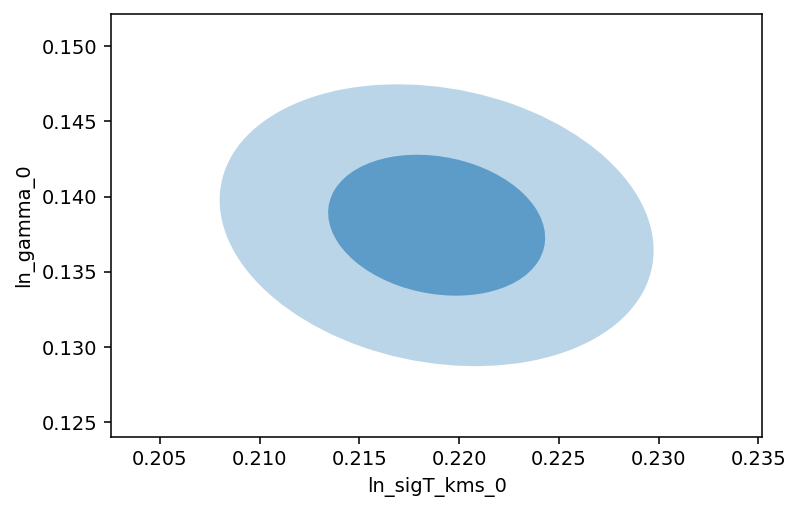

In [20]:
minimizer.plot_ellipses('ln_sigT_kms_0','ln_gamma_0')

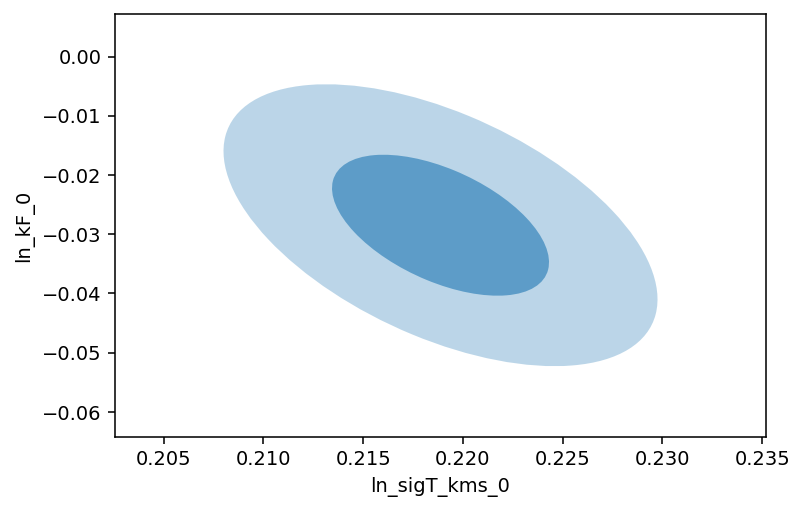

In [21]:
minimizer.plot_ellipses('ln_sigT_kms_0','ln_kF_0')

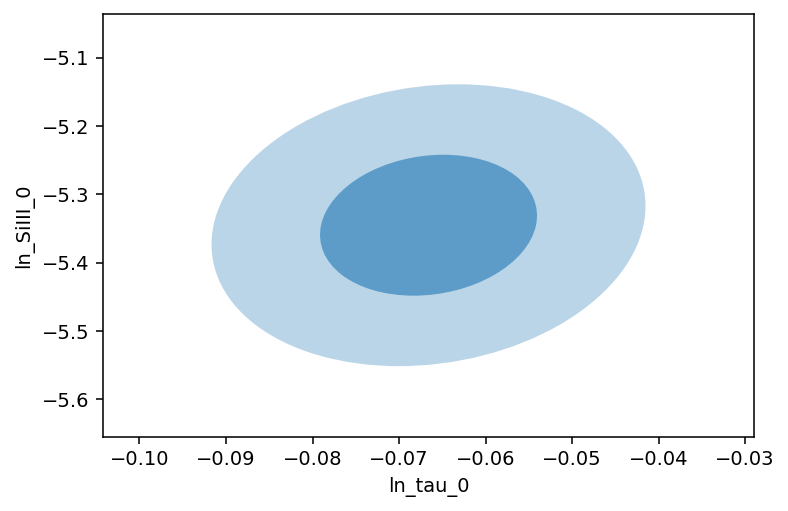

In [22]:
minimizer.plot_ellipses('ln_tau_0','ln_SiIII_0')

### Access the actual minimizer object from iminuit

In [23]:
minimizer.minimizer.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 359.9                      │              Nfcn = 355              │
│ EDM = 9.25e-14 (Goal: 0.0001)    │           time = 21.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   0.17    │   0.06    │            │            │         │         │       │
│ 1 │ x1   │   0.774   │   0.007   │            │            │         │         │       │
│ 2 │ x2   │   0.845   │   0.012   │            │            │         │         │       │
│ 3 │ x3   │   0.429   │   0.030   │            │            │         │         │       │
│ 4 │ x4   │   0.733   │   0.005   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4 │
├────┼───────────────────────────────────────────────────┤
│ x0 │   0.00393  1.31e-05  0.000249  -0.00129  4.42e-05 │
│ x1 │  1.31e-05  4.62e-05 -1.42e-05 -0.000106  3.92e-07 │
│ x2 │  0.000249 -1.42e-05  0.000137  9.73e-05  5.94e-06 │
│ x3 │  -0.00129 -0.000106  9.73e-05  0.000885 -9.32e-06 │
│ x4 │  4.42e-05  3.92e-07  5.94e-06 -9.32e-06  2.66e-05 │
└────┴───────────────────────────────────────────────────┘

In [24]:
#minimizer.minimizer.draw_mncontour("x0", "x1")

In [25]:
#minimizer.minimizer.draw_mnprofile("x0")